# <div align='center'> Test Garbage </div>

In [38]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import Image as IMG
from PIL import Image
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, models
from torchvision import datasets
from torch import optim
from torch.utils.data import (Dataset, DataLoader)
from k12libs.utils.nb_easy import K12AI_PRETRAINED_ROOT, K12AI_DATASETS_ROOT, k12ai_get_top_dir

In [2]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [3]:
dataset = 'rgarbage'
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', dataset)

In [4]:
!cat $data_root/info.json

{
    "num_records": 11073,
    "num_classes": 4,
    "label_names": [
        "其他垃圾",
        "厨余垃圾",
        "可回收物",
        "有害垃圾"
    ],
    "mean": [
        0.6535,
        0.6132,
        0.5643
    ],
    "std": [
        0.2165,
        0.2244,
        0.2416
    ]
}

In [23]:
!tree -d /data/datasets/cv/rgarbage

/data/datasets/cv/rgarbage
├── imgs
│   ├── 其他垃圾
│   │   ├── 其他垃圾_PE塑料袋
│   │   ├── 其他垃圾_一次性杯子
│   │   ├── 其他垃圾_一次性棉签
│   │   ├── 其他垃圾_串串竹签
│   │   ├── 其他垃圾_便利贴
│   │   ├── 其他垃圾_创可贴
│   │   ├── 其他垃圾_卫生纸
│   │   ├── 其他垃圾_厨房手套
│   │   ├── 其他垃圾_厨房抹布
│   │   ├── 其他垃圾_口罩
│   │   ├── 其他垃圾_奶茶杯
│   │   ├── 其他垃圾_打火机
│   │   ├── 其他垃圾_毛巾
│   │   ├── 其他垃圾_湿纸巾
│   │   ├── 其他垃圾_烟蒂
│   │   ├── 其他垃圾_牙刷
│   │   ├── 其他垃圾_眼镜
│   │   │   ├── 3D眼镜_其他垃圾
│   │   │   └── 电视眼镜_其他垃圾
│   │   ├── 其他垃圾_笔
│   │   │   ├── 白板笔_其他垃圾
│   │   │   └── 笔芯_其他垃圾
│   │   ├── 其他垃圾_酒精棉
│   │   ├── 其他垃圾_餐巾纸
│   │   └── 其他垃圾_餐盒
│   ├── 厨余垃圾
│   │   ├── 厨余垃圾_巧克力
│   │   ├── 厨余垃圾_果皮
│   │   │   ├── 花生皮_厨余垃圾
│   │   │   ├── 西瓜皮_厨余垃圾
│   │   │   ├── 陈皮_厨余垃圾
│   │   │   └── 香蕉皮_厨余垃圾
│   │   ├── 厨余垃圾_橙子
│   │   ├── 厨余垃圾_薯片
│   │   ├── 厨余垃圾_面包
│   │   │   ├── 汉堡_厨余垃圾
│   │   │   ├── 菠萝包_厨余垃圾
│   │   │   └── 面包_厨余垃圾
│   │   └── 厨余垃圾_饼干
│   │       ├── 奥利奥饼干_厨余垃圾
│   │       └── 饼干_厨余垃圾
│   ├── 可回收物
│   │   ├── 可回收物_不锈钢制品
│   │   │   └──

In [5]:
### 
with open(os.path.join(data_root, 'info.json'), 'r') as fr:
    items = json.load(fr)

### 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),    # 数据增强: 对PIL Image数据做随机水平翻转
    transforms.ToTensor(),                     # PIL Image格式转换为Tensor张量格式               
    transforms.Normalize(items['mean'], items['std']) # 对数据归一化处理
])

In [6]:
class JsonfileDataset(Dataset):
    def __init__(self, data_root, json_file, resize=None, transform=None):
        self.data_root = data_root
        self.json_file = json_file
        self.resize = resize
        self.image_list, self.label_list = self.__read_jsonfile(json_file)
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([transforms.ToTensor()])

    def __getitem__(self, index):
        img = Image.open(self.image_list[index]).convert('RGB')
        if self.resize:
            img = img.resize(self.resize)
        if self.transform is not None:
            img = self.transform(img)
        return img, self.label_list[index]

    def __len__(self):
        return len(self.image_list)

    def __read_jsonfile(self, jsonfile):
        image_list = []
        label_list = []
        with open(os.path.join(self.data_root, self.json_file)) as f:
            items = json.load(f)
            for item in items:
                image_list.append(os.path.join(self.data_root, item['image_path']))
                label_list.append(item['label'])
        return image_list, label_list

In [12]:
train_data = JsonfileDataset(data_root, 'all.json', transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True) 

valid_data = JsonfileDataset(data_root, 'val.json', transform=transform)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True, drop_last=False) 

In [13]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)

# model = models.vgg16_bn(pretrained=True)
# model.classifier[6] = nn.Linear(4096, 4)

model = model.to('cuda')

## 超参数调整

In [14]:
### 设置训练轮回(max_epoch)
max_epoch = 100

### 设置损失函数(交叉熵CE)
reduction = 'mean' # 约简方式为mean(张量各个维度上的元素的平均值)
criterion = nn.CrossEntropyLoss(reduction=reduction)

### 设置优化器(随机梯度下降SGD)
# optimizer = SGD(model.parameters(),
#    lr=0.01,           # 基础学习率
#    weight_decay=1e-6, # 权重衰减, 使得模型参数值更小, 有效防止过拟合
#    momentum=0.9,      # 动量因子, 更快局部收敛
#    nesterov=True      # 使用Nesterov动量, 加快收敛速度
# )  

### 亚当
optimizer = Adam(
    filter(lambda p: p.requires_grad, model.parameters()), # 过程出可更新的层(参数)
    lr=0.001,           # 基础学习率
    betas=(0.9, 0.999), # 计算梯度的均值(0.9)和平方(0.999)的系数
    eps=1e-8,           # 为了防止分母除零, 分母加上非常小的值
    weight_decay=0,     # 权重衰减
    amsgrad=True,      # 是否使用AmsGrad变体
)

### 设置学习率衰减策略(可选, 固定步长衰减StepLR)
# scheduler = StepLR(optimizer,
#    step_size=2, # 每间隔2次epoch进行一次LR调整
#    gamma=0.6    # LR调整为原来0.6倍
# )                 
 
scheduler = ReduceLROnPlateau(
    optimizer,   # 优化器
    mode='min',  # 指定指标不再下降
    factor=0.1,  # 衰减因子
    patience=2,  # 容忍多少次(指标不改变)
    min_lr=1e-8, # 最小的lr
    eps=1e-6,    # 学习率衰减到的最小值eps时,学习率不再改变
)


## 模型训练及反馈

In [15]:
def train_epoch(model, device, data_loader, criterion, optimizer, epoch):
    ### 模型进入训练状态(启用 BN 和 Dropout)
    model.train()
    for i, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()
        if i % 30 == 0:
            print('Epoch:', epoch, 'Training Loss:', loss.item())
    print('Epoch:', epoch, ', Training Loss:', loss.item())
        
def valid_epoch(model, device, data_loader, criterion, epoch):
    ### 模型进入评估模式(禁用 BN 和 Dropou)
    model.eval()
    correct = 0
    with torch.no_grad():
        losses = []
        for i, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            pred = torch.max(output, 1)[1]
            correct += (pred == target).sum().item()
            if i % 30 == 0:
                print('Epoch:', epoch, 'Validing Loss:', loss.item())
            losses.append(loss)
        avg_loss = torch.stack(losses).mean()
    ### 计算正确率
    acc = 100.0 * correct / len(data_loader.dataset)
    ### 调整学习率
    scheduler.step(avg_loss)
    print('Epoch:', epoch, 'LR:', scheduler._last_lr, 'Validing Avg Loss:', avg_loss.item(), 'ACC:', acc)
    return acc
    
def train(epoch_num, model, train_loader, valid_loader, criterion, optimizer, scheduler):
    ### 获取模型训练所用设备(cpu或者gpu)
    device = next(model.parameters()).device
    for epoch in range(0, epoch_num):
        ### 训练模型
        train_epoch(model, device, train_loader, criterion, optimizer, epoch)
        ### 校验模型
        valid_epoch(model, device, valid_loader, criterion, epoch)

    ### 保存模型
    torch.save(model.state_dict(), "last.pt")
        
### 启动训练
train(max_epoch, model, train_loader, valid_loader, criterion, optimizer, scheduler)

Epoch: 0 Training Loss: 1.3161461353302002
Epoch: 0 Training Loss: 0.6986069679260254
Epoch: 0 Training Loss: 0.47555744647979736
Epoch: 0 Training Loss: 0.4605655074119568
Epoch: 0 Training Loss: 0.589466392993927
Epoch: 0 Training Loss: 0.7348800301551819
Epoch: 0 , Training Loss: 0.6633662581443787
Epoch: 0 Validing Loss: 0.6290017366409302
Epoch: 0 Validing Loss: 0.6624038815498352
Epoch: 0 LR: [0.001] Validing Avg Loss: 0.604125440120697 ACC: 77.32456140350877
Epoch: 1 Training Loss: 0.44208621978759766
Epoch: 1 Training Loss: 0.5066230297088623
Epoch: 1 Training Loss: 0.6898966431617737
Epoch: 1 Training Loss: 0.5299423336982727
Epoch: 1 Training Loss: 0.8105475902557373
Epoch: 1 Training Loss: 0.36504271626472473
Epoch: 1 , Training Loss: 0.4034499228000641
Epoch: 1 Validing Loss: 0.30048149824142456
Epoch: 1 Validing Loss: 0.24311700463294983
Epoch: 1 LR: [0.001] Validing Avg Loss: 0.3883057236671448 ACC: 85.74561403508773
Epoch: 2 Training Loss: 0.4059677720069885
Epoch: 2 Tra

Epoch: 17 Training Loss: 0.022274943068623543
Epoch: 17 Training Loss: 0.01376253180205822
Epoch: 17 Training Loss: 0.028693540021777153
Epoch: 17 Training Loss: 0.024551987648010254
Epoch: 17 Training Loss: 0.06443383544683456
Epoch: 17 , Training Loss: 0.039104852825403214
Epoch: 17 Validing Loss: 0.019678600132465363
Epoch: 17 Validing Loss: 0.11028698831796646
Epoch: 17 LR: [0.001] Validing Avg Loss: 0.02515757828950882 ACC: 98.90350877192982
Epoch: 18 Training Loss: 0.04623186215758324
Epoch: 18 Training Loss: 0.028422759845852852
Epoch: 18 Training Loss: 0.014116627164185047
Epoch: 18 Training Loss: 0.03719839081168175
Epoch: 18 Training Loss: 0.0458667054772377
Epoch: 18 Training Loss: 0.13478390872478485
Epoch: 18 , Training Loss: 0.012938132509589195
Epoch: 18 Validing Loss: 0.0555301271378994
Epoch: 18 Validing Loss: 0.04976328834891319
Epoch: 18 LR: [0.001] Validing Avg Loss: 0.03402620553970337 ACC: 98.7719298245614
Epoch: 19 Training Loss: 0.005679287947714329
Epoch: 19 Tr

Epoch: 33 Validing Loss: 0.0004369869420770556
Epoch: 33 LR: [1.0000000000000002e-06] Validing Avg Loss: 0.0007462525391019881 ACC: 100.0
Epoch: 34 Training Loss: 0.00948219932615757
Epoch: 34 Training Loss: 0.0021999359596520662
Epoch: 34 Training Loss: 0.002140849130228162
Epoch: 34 Training Loss: 0.002137203235179186
Epoch: 34 Training Loss: 0.03709329664707184
Epoch: 34 Training Loss: 0.001959125977009535
Epoch: 34 , Training Loss: 0.00034323977888561785
Epoch: 34 Validing Loss: 0.0004356947902124375
Epoch: 34 Validing Loss: 0.0001352639083052054
Epoch: 34 LR: [1.0000000000000002e-06] Validing Avg Loss: 0.000623766565695405 ACC: 100.0
Epoch: 35 Training Loss: 0.0007986193522810936
Epoch: 35 Training Loss: 0.0003498715814203024
Epoch: 35 Training Loss: 0.00060857372591272
Epoch: 35 Training Loss: 0.003108949400484562
Epoch: 35 Training Loss: 0.005041081458330154
Epoch: 35 Training Loss: 0.004891631193459034
Epoch: 35 , Training Loss: 0.0010118979262188077
Epoch: 35 Validing Loss: 0.

Epoch: 49 Validing Loss: 0.0005853657494299114
Epoch: 49 LR: [1.0000000000000002e-06] Validing Avg Loss: 0.0005564384628087282 ACC: 100.0
Epoch: 50 Training Loss: 0.005641231779009104
Epoch: 50 Training Loss: 0.001158286351710558
Epoch: 50 Training Loss: 0.00028101628413423896
Epoch: 50 Training Loss: 0.002571304328739643
Epoch: 50 Training Loss: 0.0036945294123142958
Epoch: 50 Training Loss: 0.0005443409318104386
Epoch: 50 , Training Loss: 0.0015306331915780902
Epoch: 50 Validing Loss: 0.0009918708819895983
Epoch: 50 Validing Loss: 0.0002741255157161504
Epoch: 50 LR: [1.0000000000000002e-06] Validing Avg Loss: 0.0005251698312349617 ACC: 100.0
Epoch: 51 Training Loss: 0.002306760987266898
Epoch: 51 Training Loss: 0.000935423478949815
Epoch: 51 Training Loss: 0.0017671359237283468
Epoch: 51 Training Loss: 0.00028281539562158287
Epoch: 51 Training Loss: 0.001379029476083815
Epoch: 51 Training Loss: 0.000983689446002245
Epoch: 51 , Training Loss: 0.0029011389706283808
Epoch: 51 Validing L

Epoch: 65 Validing Loss: 0.0005451466422528028
Epoch: 65 LR: [1.0000000000000002e-06] Validing Avg Loss: 0.0005636604619212449 ACC: 100.0
Epoch: 66 Training Loss: 0.00037326887832023203
Epoch: 66 Training Loss: 0.005013441666960716
Epoch: 66 Training Loss: 0.002058593323454261
Epoch: 66 Training Loss: 0.0032262562308460474
Epoch: 66 Training Loss: 0.0008329111733473837
Epoch: 66 Training Loss: 0.0009552795672789216
Epoch: 66 , Training Loss: 0.002494129352271557
Epoch: 66 Validing Loss: 0.000819746230263263
Epoch: 66 Validing Loss: 0.00019573088502511382
Epoch: 66 LR: [1.0000000000000002e-06] Validing Avg Loss: 0.0006293921614997089 ACC: 100.0
Epoch: 67 Training Loss: 0.002426941180601716
Epoch: 67 Training Loss: 0.0009923427132889628
Epoch: 67 Training Loss: 0.00029965079738758504
Epoch: 67 Training Loss: 0.00021889040363021195
Epoch: 67 Training Loss: 0.0008504462311975658
Epoch: 67 Training Loss: 0.01295034121721983
Epoch: 67 , Training Loss: 0.00022569499560631812
Epoch: 67 Validin

Epoch: 81 Validing Loss: 0.00025214909692294896
Epoch: 81 LR: [1.0000000000000002e-06] Validing Avg Loss: 0.0005493700737133622 ACC: 100.0
Epoch: 82 Training Loss: 0.002429474610835314
Epoch: 82 Training Loss: 0.0014217137359082699
Epoch: 82 Training Loss: 0.0011143271112814546
Epoch: 82 Training Loss: 0.0007667909376323223
Epoch: 82 Training Loss: 0.01319861225783825
Epoch: 82 Training Loss: 0.0019022613996639848
Epoch: 82 , Training Loss: 0.0013661065604537725
Epoch: 82 Validing Loss: 0.0004506442346610129
Epoch: 82 Validing Loss: 0.0004668178444262594
Epoch: 82 LR: [1.0000000000000002e-06] Validing Avg Loss: 0.0005307996761985123 ACC: 100.0
Epoch: 83 Training Loss: 0.0001288015628233552
Epoch: 83 Training Loss: 0.0018509634537622333
Epoch: 83 Training Loss: 0.0021028693299740553
Epoch: 83 Training Loss: 0.0015943726757541299
Epoch: 83 Training Loss: 0.00251872930675745
Epoch: 83 Training Loss: 0.00019824691116809845
Epoch: 83 , Training Loss: 0.0024546838831156492
Epoch: 83 Validing

Epoch: 97 Validing Loss: 0.00039734135498292744
Epoch: 97 LR: [1.0000000000000002e-06] Validing Avg Loss: 0.0004691104986704886 ACC: 100.0
Epoch: 98 Training Loss: 0.00269921007566154
Epoch: 98 Training Loss: 0.0017736711306497455
Epoch: 98 Training Loss: 0.0013394075213000178
Epoch: 98 Training Loss: 0.00017212539387401193
Epoch: 98 Training Loss: 0.012426384724676609
Epoch: 98 Training Loss: 0.0004655187367461622
Epoch: 98 , Training Loss: 0.00022013044508639723
Epoch: 98 Validing Loss: 0.0008114493102766573
Epoch: 98 Validing Loss: 0.0005337519687600434
Epoch: 98 LR: [1.0000000000000002e-06] Validing Avg Loss: 0.0006012589437887073 ACC: 100.0
Epoch: 99 Training Loss: 0.0024438572581857443
Epoch: 99 Training Loss: 0.000934698386117816
Epoch: 99 Training Loss: 0.0016438248567283154
Epoch: 99 Training Loss: 0.0011762087233364582
Epoch: 99 Training Loss: 0.0003824218292720616
Epoch: 99 Training Loss: 0.0004993891925550997
Epoch: 99 , Training Loss: 0.0012807592283934355
Epoch: 99 Validi

## 模型评估及测试

In [20]:
### 加载测试数据集
test_data = JsonfileDataset(data_root, 'test.json', transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=False) 

### 加载训练完成的模型
test_model = models.resnet18(pretrained=False)
test_model.fc = nn.Linear(test_model.fc.in_features, 4)
test_model.load_state_dict(torch.load('last.pt'))

def evaluate(model, data_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            pred = torch.max(output, 1)[1]
            correct += (pred == target).sum().item()
    ### 计算正确率
    acc = 100.0 * correct / len(data_loader.dataset)
    return acc

### 启动评估
acc = evaluate(test_model, test_loader)
print("Acc:", acc)

Acc: 100.0


In [43]:
def predict(model, img_path):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
        ])

    inputs = transform(img).unsqueeze(0)

    with torch.no_grad():
        outputs = model(inputs)
        result = outputs.argmax(dim=1).item()

    return result                                           

test_pic1 = os.path.join(k12ai_get_top_dir(), 'assets/images', 'garbage_earphone.jpg')
test_pic2 = os.path.join(k12ai_get_top_dir(), 'assets/images', 'garbage_bread.jpeg')
test_pic3 = os.path.join(k12ai_get_top_dir(), 'assets/images', 'garbage_thermometer.jpeg')
items['label_names'][predict(test_model, test_pic1)], \
items['label_names'][predict(test_model, test_pic2)], \
items['label_names'][predict(test_model, test_pic3)]

('可回收物', '厨余垃圾', '有害垃圾')

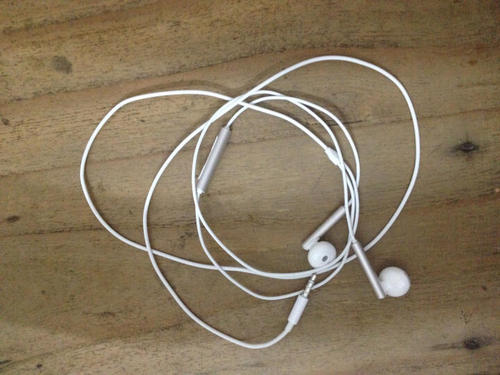

In [45]:
IMG(test_pic1)

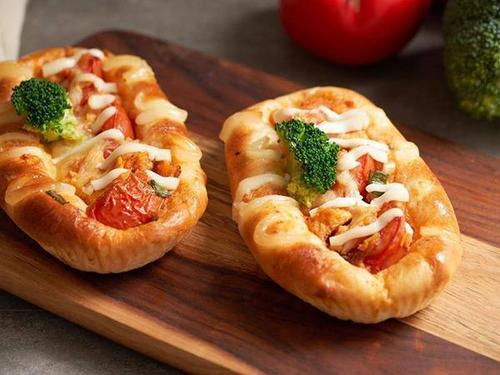

In [44]:
IMG(test_pic2)